# PyTorch Lab 4

Written by Prachya Boonkwan (Arm)

In [0]:
!pip install -q torch torchvision tqdm nltk
import nltk
nltk.download('nps_chat')
nltk.download('punkt')

[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Package nps_chat is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Document Classification

In this workshop, we are going to implement a document classifier based on convolutional neural networks.

## Header

This part is the header of the code. My favorite import aliases for PyTorch are as follows. This will be very useful for speed coding.

In [0]:
#!/usr/bin/env python3
#-*- coding: utf-8 -*-

import torch as T
import torch.nn as N
import torch.optim as O

from tqdm import tqdm    # Nice progressbar
import matplotlib.pyplot as plt
%matplotlib inline

import random

if T.cuda.is_available():
    print('Feel free to use GPU acceleration.')
else:
    print('GPU is not available at this time.')

use_cuda = True   # False

GPU is not available at this time.




---



## Data Preparation

### Using Free Dataset from NPS Chatlogs

We will use a free dataset from NPS Chat Corpus. It contains 10k sentences annotated with 16 categories (a.k.a. *intent*). The intents are as follows:

- Accept
- Bye
- Clarify
- Continuer
- Emotion
- Emphasis
- Greet
- Reject
- Statement
- System
- ynQuestion
- whQuestion
- yAnswer
- nAnswer
- Other

In [0]:
from nltk.corpus import nps_chat

corpus = [ (nltk.word_tokenize(post.text), post.get('class'))
           for post in nps_chat.xml_posts() ]
random.shuffle(corpus)

crplen = len(corpus)
print('Number of sentences = {}'.format(crplen))

no_words = sum(len(sent[0]) for sent in corpus)
print('Number of words     = {}'.format(no_words))

max_sentlen = max(len(sent[0]) for sent in corpus)
print('Max number of words = {}'.format(max_sentlen))

Number of sentences = 10567
Number of words     = 46870
Max number of words = 87


### Indexing Words and Intents

In [0]:
all_words = set()
all_intents = set()
for (sent, intent) in corpus:
    all_words.update(set(sent))
    all_intents.add(intent)

In [0]:
idx2word = [None] + sorted(all_words)

idx2intent = [None] + sorted(all_intents)

no_words = len(idx2word)
no_intents = len(idx2intent)
print('Number of words   = {}'.format(no_words))
print('Number of intents = {}'.format(no_intents))

Number of words   = 6783
Number of intents = 16


In [0]:
word2idx = {}
for (idx, word) in enumerate(idx2word):
    word2idx[word] = idx
print(len(word2idx))

6783


In [0]:
intent2idx = {}
for (idx, tag) in enumerate(idx2intent):
    intent2idx[tag] = idx
print(len(intent2idx))

16


### Conversion between Sentence and Index Sequence

In [0]:
def sent2idxseq(sent, max_sentlen=None):
    wordidxseq = []
    for word in sent:
        word = word.lower()
        if word in word2idx:
            wordidxseq.append(word2idx[word])
        else:
            wordidxseq.append(word2idx[None])
    return to_sentlen(wordidxseq, max_sentlen)

def to_sentlen(wordidxseq, max_sentlen=None):
    result = wordidxseq
    seqlen = len(wordidxseq)
    if max_sentlen is not None:
        if seqlen < max_sentlen:
            result = result + (max_sentlen - seqlen) * [word2idx[None]]
        else:
            result = result[: max_sentlen]
    return result

In [0]:
wordidxseq1 = sent2idxseq('I am a boy .'.split())
print(wordidxseq1)

wordidxseq2 = sent2idxseq('I am a boy .'.split(), max_sentlen=10)
print(wordidxseq2)

[4128, 2236, 2110, 2593, 87]
[4128, 2236, 2110, 2593, 87, 0, 0, 0, 0, 0]


In [0]:
def idxseq2sent(wordidxseq):
    result = []
    for i in range(len(wordidxseq)):
        wordidx = wordidxseq[i]
        if wordidx < len(idx2word):
            word = idx2word[wordidx]
            if word is not None:
                result.append(word)
    return ' '.join(result)

In [0]:
s = idxseq2sent(wordidxseq1)
print(s)

i am a boy .




---



### Preparing Training and Testing Sets

In [0]:
def corpus2dataset(corpus):
    dataset = []
    for (sent, intent) in corpus:
        wordidxseq = sent2idxseq(sent)
        intentidx = intent2idx[intent]
        dataset.append((wordidxseq, intentidx))
    return dataset

In [0]:
crp = [ ('i am a boy'.split(), 'Statement'),
        ('you are a boy too'.split(), 'Statement') ]
ds = corpus2dataset(crp)
print(ds)

[([4128, 2236, 2110, 2593], 10), ([6744, 2286, 2110, 2593, 6241], 10)]


In [0]:
training_len = int(crplen * 0.8)           # 80% for training, 20% for testing
training_set = corpus2dataset(corpus[: training_len])
testing_set = corpus2dataset(corpus[training_len :])
print('Size of training set = {}'.format(len(training_set)))
print('Size of testing set = {}'.format(len(testing_set)))

Size of training set = 8453
Size of testing set = 2114




---



## Convolutional Neural Networks

A convolutional neural network learns to *extract* a number of local features from each fixed-size sliding window. When applying to NLP, we usually extract local features from a 1-directional window, which is equivalent to learning idioms and phrases from text. In most cases, CNN architectures require fix-sized inputs. It is therefore much easier to perform batch training.

The command `N.Conv1d(` $C_\textrm{in}$, $C_\textrm{out}$, $K$ `)` takes into account $K$ consecutive column vectors of size $C_\textrm{in}$ and extracts out of them  $C_\textrm{out}$ local features represented as a vector.

- $C_\textrm{in}$ is the size of input vectors.
- $C_\textrm{out}$ is the size of output vectors.
-  $K$ is the window size, a.k.a. *kernel size*.  It can be seen as the size of the input sliding window.

For example, `N.Conv1d(10, 5, 3)`  considers 3 consecutive column vectors of size 10 and extracts 5 local features as a vector.

A useful option worth mentioning of this command is `stride`. Stride is the sliding window's stepsize. It is recommended that the stride should be explicitly specified to avoid misunderstanding.

In [0]:
cnn_layer = N.Conv1d(10, 5, 3, stride=1)
print(cnn_layer)

Conv1d(10, 5, kernel_size=(3,), stride=(1,))


In [0]:
data = T.randn(1, 10, 7)
print('input =\n{}'.format(data)); print()

out1 = cnn_layer(data)
print('output =\n{}'.format(out1))

input =
tensor([[[-0.6796, -0.4778,  0.0434, -0.2473, -0.5832, -1.1902, -0.6629],
         [-0.7261,  0.4516, -1.4756,  0.1824,  1.5712,  0.2506,  0.2631],
         [-0.8254,  0.0972, -0.8899,  0.1931, -0.0040, -3.4401,  0.7553],
         [-0.6647,  1.1529, -0.2143,  0.9015, -0.8694,  0.9513,  0.6247],
         [ 2.0010,  0.4076,  0.0544,  0.2946,  0.9485, -1.7357,  1.4959],
         [ 0.0397,  0.5264, -0.9628, -0.0639, -0.8890, -0.9859,  2.0065],
         [-0.2035, -1.6826, -0.5635, -0.4028, -0.9481,  2.1565,  0.4520],
         [ 0.7625, -0.4475,  0.1140, -0.7932,  0.0540, -1.6394,  0.3054],
         [-0.2030, -0.5054,  0.9736,  0.0834, -0.9378, -1.7403, -0.4746],
         [ 1.4477, -0.8140, -0.0904, -0.1036,  0.8669, -0.7689, -1.6343]]])

output =
tensor([[[-0.5019,  0.7081, -0.2120,  0.0765,  1.0313],
         [ 0.5082, -0.2611, -0.4612,  0.3059,  0.5008],
         [-0.8113,  0.1165, -0.0051,  0.1157,  0.3530],
         [-0.1704,  0.3776, -0.2290,  0.0395, -0.7594],
         [-0.236

## Pooling

Pooling is to *select* an optimal feature out of a set of input features. Each pooling function selects a different kind of features. For example,

- Max pooling extracts the most prominent feature.
- Min pooling extracts the most subtle feature.
- Average pooling averages all input features.

In NLP, we usually take into account the max pooling due to its ability to select the most prominent one out of the features extracted by the CNNs.

The command `N.MaxPool1d(` $C_\textrm{in}$ `)` inputs $C_\textrm{in}$ vectors of the same dimension and selects the maximum element on each dimension. One of its useful options worth mentioning is `stride`. Stride is the sliding window's stepsize. It is recommended that the stride should be explicitly specified to avoid misunderstanding.

In [0]:
pool = N.MaxPool1d(2, stride=1)
out2 = pool(out1)
print(out2)

tensor([[[ 0.7081,  0.7081,  0.0765,  1.0313],
         [ 0.5082, -0.2611,  0.3059,  0.5008],
         [ 0.1165,  0.1165,  0.1157,  0.3530],
         [ 0.3776,  0.3776,  0.0395,  0.0395],
         [-0.0750, -0.0227, -0.0227, -0.0937]]], grad_fn=<SqueezeBackward1>)


## Flattening

There is no direct command for flattening a tensor. However, we can flatten an input tensor with the command `view`. For example, a tensor `tsr` can be simply flattened with the command `tsr.view(tsr.size(0) * tsr.size(1) * tsr.size(2))`.

In [0]:
print(out2.view(out2.size(0) * out2.size(1) * out2.size(2)))

tensor([ 0.7081,  0.7081,  0.0765,  1.0313,  0.5082, -0.2611,  0.3059,  0.5008,
         0.1165,  0.1165,  0.1157,  0.3530,  0.3776,  0.3776,  0.0395,  0.0395,
        -0.0750, -0.0227, -0.0227, -0.0937], grad_fn=<ViewBackward>)




---



## Document Classification Model

### Neural Architecture

The neural architecture for document classification used in this workshop is based on CNNs. There are five layers in this architecture.

1. Word embedding layer
2. 1-D CNN with the sliding window's size of 4
3. 1-D max pooling with the sliding window's size of 2
4. 1-D CNN with the sliding window's size of 4
5. 1-D max pooling with the sliding window's size of 2
6. Flattening layer
7. Hidden layer

In [0]:
class DocumentClassifier(N.Module):
    
    def __init__(
        self, no_words, no_classes, dim_word, dim_chan1, dim_chan2, dim_hidden
    ):
        super(DocumentClassifier, self).__init__()
        
        self._no_words = no_words
        self._no_classes = no_classes
        self._max_sentlen = 64             # performing on the 64 first words
        self._dim_word = dim_word
        self._dim_chan1 = dim_chan1
        self._dim_chan2 = dim_chan2
        self._dim_hidden = dim_hidden
        
        self._wordemb = N.Embedding(self._no_words, self._dim_word)
        self._cnn1 = N.Conv1d(self._dim_word, self._dim_chan1, 4, stride=4)
        self._pool1 = N.MaxPool1d(2, stride=2)
        self._cnn2 = N.Conv1d(self._dim_chan1, self._dim_chan2, 4, stride=4)
        self._pool2 = N.MaxPool1d(2, stride=2)
        self._hidden = N.Linear(self._dim_chan2, self._no_classes)
        self._relu = N.ReLU()
        
    def forward(self, wordidxseq):
        wordidxseq = to_sentlen(wordidxseq, self._max_sentlen)
        wordvecs = self._wordemb(T.LongTensor(wordidxseq)).t().unsqueeze(0)

        out1 = self._cnn1(wordvecs)
        pool1 = self._pool1(out1)
        relu1 = self._relu(pool1)

        out2 = self._cnn2(relu1)
        pool2 = self._pool2(out2)
        relu2 = self._relu(pool2)
        
        # Flatten
        flat = relu2.view(relu2.size(0), relu2.size(1) * relu2.size(2))

        clsvec = self._hidden(flat)
        return clsvec
    
    def forward_batch(self, wordidxseqs):
        wordidxseqs = [ to_sentlen(wordidxseq, self._max_sentlen)
                        for wordidxseq in wordidxseqs ]
        
        wordvecs = self._wordemb(T.LongTensor(wordidxseqs)).transpose(1, 2)

        out1 = self._cnn1(wordvecs)
        pool1 = self._pool1(out1)
        relu1 = self._relu(pool1)

        out2 = self._cnn2(relu1)
        pool2 = self._pool2(out2)
        relu2 = self._relu(pool2)
        
        # Flatten
        flat = relu2.view(relu2.size(0), relu2.size(1) * relu2.size(2))

        clsvec = self._hidden(flat)
        return clsvec



---



### Feed-Forwarding and Loss Function

In [0]:
doccls_model = DocumentClassifier(no_words, no_intents, 10, 10, 10, 8)

wordidxs = sent2idxseq('i am a boy'.split())

outvec = doccls_model(wordidxs)
print(outvec)

tensor([[-0.0826,  0.0488, -0.1913,  0.1174, -0.2180,  0.3835, -0.3345,  0.0988,
          0.1701,  0.0497, -0.2404,  0.0930, -0.2486,  0.0616, -0.1937,  0.1620]],
       grad_fn=<ThAddmmBackward>)


In [0]:
loss_fn = N.CrossEntropyLoss()
goldvec = T.LongTensor([1])
loss = loss_fn(outvec, goldvec)
print(loss)

tensor(2.7223, grad_fn=<NllLossBackward>)


### Batch Feed-Forwarding and Batch Loss Function

In [0]:
doccls_model = DocumentClassifier(no_words, no_intents, 10, 10, 10, 8)

wordidxs1 = sent2idxseq('i am a boy'.split())
wordidxs2 = sent2idxseq('this is a girl'.split())

outvec = doccls_model.forward_batch([wordidxs1, wordidxs2])
print(outvec)

tensor([[-0.1657, -0.2480,  0.2450, -0.2109,  0.2794, -0.1401,  0.0945, -0.0701,
         -0.2948, -0.0743,  0.1639,  0.0008,  0.0764,  0.1640,  0.1994,  0.0737],
        [-0.1829, -0.2805,  0.2708, -0.1853,  0.2686, -0.1716,  0.1082, -0.0540,
         -0.2920, -0.1124,  0.1652, -0.0295,  0.0856,  0.1700,  0.2375,  0.0799]],
       grad_fn=<ThAddmmBackward>)


In [0]:
loss_fn = N.CrossEntropyLoss()
goldvec = T.LongTensor([1, 1])
loss = loss_fn(outvec, goldvec)
print(loss)

tensor(3.0586, grad_fn=<NllLossBackward>)




---



### Training Procedure

There are two kinds of traning strategies: online and batch training.

- In the online training strategy, each training item is used to gradually estimate the parameters. 
- The batch training strategy boosts the speed of training by estimating the parameters from a small collection of training items using parallel processing.

In most cases, batch training yields better accuracy and speed because more training items are considered given the same amount of training time.

In [0]:
def train_model_online(doccls_model, training_data, epochs, loss_fn, optimizer):
    no_samples = len(training_data)
    loss_history = []
    
    for i in range(epochs):
        total_loss = 0.0
        random.shuffle(training_data)
        
        for (wordidxs, clsidx) in tqdm(training_data):
            pred_clsvec = doccls_model(wordidxs)       # Perform prediction
            gold_clsvec = T.LongTensor([clsidx])       # Gold standard
            
            loss = loss_fn(pred_clsvec, gold_clsvec)
            total_loss += loss.item()
            
            optimizer.zero_grad()      # Clear gradient cache
            loss.backward()            # Perform backpropagation
            optimizer.step()           # Update the model parameters
        
        loss_history.append(total_loss / no_samples)
        
    # Plot the loss history with Matplotlib
    epoch_count = range(1, epochs + 1)
    plt.plot(epoch_count, loss_history, 'b--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

100%|██████████| 8453/8453 [00:44<00:00, 191.56it/s]


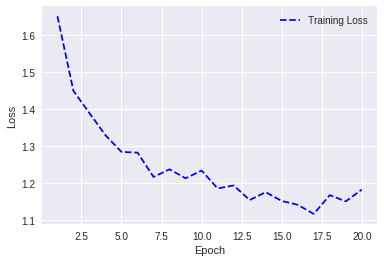

In [0]:
doccls_model_online = DocumentClassifier(no_words, no_intents, 10, 10, 10, 8)

if use_cuda and T.cuda.is_available():
    doccls_model_online.cuda()

epochs = 20
learning_rate = 0.01

loss_fn = N.CrossEntropyLoss()
optimizer = O.Adam(doccls_model_online.parameters(), lr=learning_rate)
train_model_online(doccls_model_online, training_set, epochs, loss_fn, optimizer)



---



### Batch Training Procedure

In the batch training strategy, we divide the training set into small *mini-batches*, collections of training items, and feed them one by one to estimate the parameters.

In [0]:
def batch_ranges(no_items, batch_size):
    batches = []
    begpos = 0
    for i in range(no_items // batch_size):
        endpos = min((i + 1) * batch_size, no_items)
        batches.append(range(begpos, endpos))
        begpos = endpos
    return batches

def train_model_batch(
    doccls_model, training_data, epochs, loss_fn, optimizer, batch_size=10
):
    no_samples = len(training_data)
    loss_history = []
    
    for i in range(epochs):
        total_loss = 0.0
        random.shuffle(training_data)
        batches = batch_ranges(len(training_data), batch_size)
        
        for batch in tqdm(batches):
            wordidxseqs = [training_data[i][0] for i in batch]
            clsidxs = [training_data[i][1] for i in batch]
            
            pred_clsvec = doccls_model.forward_batch(wordidxseqs)   # Perform prediction
            gold_clsvec = T.LongTensor(clsidxs)                     # Gold standard

            loss = loss_fn(pred_clsvec, gold_clsvec)
            total_loss += loss.item()

            optimizer.zero_grad()      # Clear gradient cache
            loss.backward()            # Perform backpropagation
            optimizer.step()           # Update the model parameters
        
        loss_history.append(total_loss / len(batches))
        
    # Plot the loss history with Matplotlib
    epoch_count = range(1, epochs + 1)
    plt.plot(epoch_count, loss_history, 'b--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

100%|██████████| 845/845 [00:03<00:00, 233.94it/s]


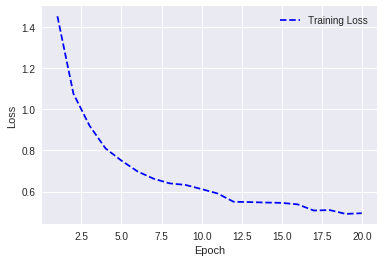

In [0]:
doccls_model_batch = DocumentClassifier(no_words, no_intents, 10, 10, 10, 8)

if use_cuda and T.cuda.is_available():
    doccls_model_batch.cuda()

epochs = 20
learning_rate = 0.01

loss_fn = N.CrossEntropyLoss()
optimizer = O.Adam(doccls_model_batch.parameters(), lr=learning_rate)
# train_model(doccls_model, training_set, epochs, loss_fn, optimizer)
train_model_batch(doccls_model_batch, training_set, epochs, loss_fn, optimizer, batch_size=10)

### Exercise

Note that the model converges much faster and more smoother when batch training is used. Explain why it helps make the model converge.



---



### Classification

In [0]:
def classify(doccls_model, sent):
    wordidxs = sent2idxseq(sent)
    pred_clsvec = doccls_model(wordidxs)
    return pred_clsvec.argmax(dim=1)

In [0]:
def classify_batch(doccls_model, sents):
    wordidxseqs = [ sent2idxseq(sent)
                    for sent in sents ]
    pred_clsvecs = doccls_model.forward_batch(wordidxseqs)
    return pred_clsvecs.argmax(dim=1)

In [0]:
cls = classify(doccls_model, 'hey'.split())
print(cls)

clsseq = classify_batch(doccls_model, [ 'i am a boy'.split(),
                                        'this is a girl'.split() ])
print(clsseq)

tensor([4])
tensor([4, 2])




---



### Testing Procedure

In [0]:
def test_model(doccls_model, testing_data):
    no_correct = 0.0
    no_total = 0.0

    for (wordidxs, clsidx) in tqdm(testing_data):
        pred_clsvec = doccls_model(wordidxs)
        pred_clsidx = pred_clsvec.argmax(dim=1)[0]
        if pred_clsidx == clsidx: no_correct += 1.0
        no_total += 1.0

    acc = 100 * no_correct / no_total
    
    print('\nAccuracy = {}'.format(acc))

In [0]:
print('Accuracy of online training:')
test_model(doccls_model_online, testing_set)

 13%|█▎        | 283/2114 [00:00<00:00, 2822.28it/s]

Accuracy of online training:


100%|██████████| 2114/2114 [00:00<00:00, 2841.58it/s]


Accuracy = 50.047303689687794


In [0]:
print('Accuracy of batch training:')
test_model(doccls_model_batch, testing_set)

 13%|█▎        | 268/2114 [00:00<00:00, 2673.02it/s]

Accuracy of batch training:


100%|██████████| 2114/2114 [00:00<00:00, 2858.74it/s]


Accuracy = 72.42194891201514




---



## Exercises

Note that the model takes into account the first 64 words of the input string. Let's modify the model for other input settings.

1. If you want to narrow the input size to the first 32 words, how would you modify the CNN architecture?

2. If you want to expand the input size to the first 128 words, how would you modify the CNN architecture?

3. If you want to expand the input size to the first 100 words, how would you modify the CNN architecture?

4. If you want the model to consider every word in the input string, how would you modify the CNN architecture?